# Working with Cassandra in Python

This notebook demonstrates how to work with Cassandra using Python's `cassandra-driver` library. We'll connect to our single-node Cassandra cluster and perform basic operations.

## Prerequisites

- The Docker Compose environment is up and running with Cassandra
- The `cassandra-driver` Python library is installed

In [1]:
# Import required libraries
import time
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Connecting to Cassandra

Let's establish a connection to our Cassandra cluster. We'll implement a helper function that retries the connection a few times in case the Cassandra service is still starting up.

In [2]:
def connect_to_cassandra(max_attempts=10, delay_seconds=5):
    """Connect to Cassandra with retry logic"""
    cluster = None
    
    for attempt in range(1, max_attempts + 1):
        try:
            print(f"Connecting to Cassandra (attempt {attempt}/{max_attempts})...")
            # Connect to the Cassandra cluster - use 'cassandra' as the hostname
            # which is the service name defined in docker-compose
            cluster = Cluster(['cassandra'])
            session = cluster.connect()
            
            # Simple query to test the connection
            rows = session.execute("SELECT release_version FROM system.local")
            version = rows[0].release_version
            print(f"✅ Connected to Cassandra version: {version}")
            
            return session, cluster
        except Exception as e:
            print(f"❌ Failed to connect to Cassandra: {e}")
            if attempt < max_attempts:
                print(f"Retrying in {delay_seconds} seconds...")
                time.sleep(delay_seconds)
            else:
                print("Max attempts reached. Could not connect to Cassandra.")
                raise
        finally:
            if cluster and attempt < max_attempts and 'session' not in locals():
                cluster.shutdown()
    
    return None, None

# Connect to Cassandra
session, cluster = connect_to_cassandra()

2025-10-07 08:59:04,141 - WARNING - Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['cassandra'], lbp = None)
2025-10-07 08:59:04,143 - WARNING - Downgrading core protocol version from 66 to 65 for 172.24.0.2:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
2025-10-07 08:59:04,145 - WARNING - Downgrading core protocol version from 65 to 5 for 172.24.0.2:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
2025-10-07 08:59:04,150 - INFO - Using datacenter 'datacenter1' for DC

Connecting to Cassandra (attempt 1/10)...
✅ Connected to Cassandra version: 5.0.5


/tmp/ipykernel_4514/3575672333.py:15: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  version = rows[0].release_version


2025-10-07 08:59:04,478 - WARNING - Server warning: `USE <keyspace>` with prepared statements is considered to be an anti-pattern due to ambiguity in non-qualified table names. Please consider removing instances of `Session#setKeyspace(<keyspace>)`, `Session#execute("USE <keyspace>")` and `cluster.newSession(<keyspace>)` from your code, and always use fully qualified table names (e.g. <keyspace>.<table>). Keyspace used: example_keyspace, statement keyspace: example_keyspace, statement id: 14a4de38035de5a6dc92edd2b04e59c1


## Clean up previous session

To ensure a clean environment for our demonstration, let's start by dropping the keyspace if it exists from a previous run.

In [3]:
# Drop the keyspace if it exists to ensure a clean run
keyspace_name = "example_keyspace"
print(f"Dropping keyspace '{keyspace_name}' if it exists...")
try:
    session.execute(f"DROP KEYSPACE IF EXISTS {keyspace_name}")
    print(f"✅ Keyspace '{keyspace_name}' dropped.")
except Exception as e:
    print(f"An error occurred while dropping the keyspace: {e}")

Dropping keyspace 'example_keyspace' if it exists...
✅ Keyspace 'example_keyspace' dropped.
✅ Keyspace 'example_keyspace' dropped.


## Creating a Keyspace and Table

In Cassandra, a keyspace is similar to a database in relational database systems. Let's create a keyspace and a table to store some data.

In [4]:
# Create a keyspace
keyspace_name = "example_keyspace"
print(f"Creating keyspace '{keyspace_name}' if it doesn't exist...")

# Use SimpleStrategy with replication_factor 1 for a single-node cluster
session.execute(f"""
    CREATE KEYSPACE IF NOT EXISTS {keyspace_name} 
    WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}}
""")

# Use the keyspace
session.execute(f"USE {keyspace_name}")
print(f"Now using keyspace: {keyspace_name}")

# Create table for user data
table_name = "users"
print(f"Creating table '{table_name}' if it doesn't exist...")

session.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        user_id uuid PRIMARY KEY,
        username text,
        email text,
        age int,
        created_at timestamp
    )
""")

Creating keyspace 'example_keyspace' if it doesn't exist...
Now using keyspace: example_keyspace
Creating table 'users' if it doesn't exist...


## Inserting Data

Let's insert some sample data into our users table.

In [5]:
# Prepare the statement for inserting user data
insert_stmt = session.prepare("""
    INSERT INTO users (user_id, username, email, age, created_at) 
    VALUES (uuid(), ?, ?, ?, toTimestamp(now()))
""")

# Sample user data
sample_users = [
    ("alice", "alice@example.com", 28),
    ("bob", "bob@example.com", 35),
    ("charlie", "charlie@example.com", 42),
    ("dana", "dana@example.com", 24),
    ("evan", "evan@example.com", 31)
]

# Insert the users
print("Inserting sample users...")
for username, email, age in sample_users:
    session.execute(insert_stmt, (username, email, age))

print(f"✅ Inserted {len(sample_users)} users into the database.")

Inserting sample users...
✅ Inserted 5 users into the database.


## Querying Data

Now let's retrieve the data we just inserted.

In [6]:
# Query all users
print("Querying all users...")
rows = session.execute("SELECT * FROM users")

# Convert to a pandas DataFrame for easier manipulation and display
users_df = pd.DataFrame(list(rows))
users_df

Querying all users...


,user_id,age,created_at,email,username
0,e0f61c46-5931-4daa-9720-3bfefc0ff746,31,2025-10-07 08:59:04.483,evan@example.com,evan
1,60bc26b7-7b1d-4d76-94d3-84d714b430d1,35,2025-10-07 08:59:04.481,bob@example.com,bob
2,65d17de2-554c-4fa5-b16d-80077b1eb01f,24,2025-10-07 08:59:04.482,dana@example.com,dana
3,f52b8770-ab4a-4d5a-b7a5-82d7154b1565,28,2025-10-07 08:59:04.480,alice@example.com,alice
4,f4c5c43f-fa3a-4b76-a127-a7ec33a793c0,42,2025-10-07 08:59:04.481,charlie@example.com,charlie


## Data Analysis

Let's do a simple analysis of our user data - calculating average age and visualizing the age distribution.

Average user age: 32.0


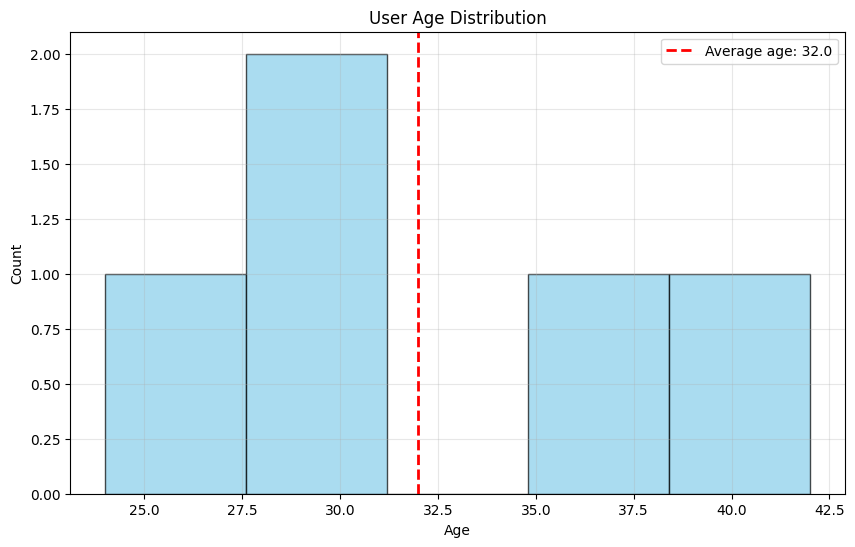

In [7]:
# Calculate average age
avg_age = users_df['age'].mean()
print(f"Average user age: {avg_age:.1f}")

# Create a histogram of ages
plt.figure(figsize=(10, 6))
plt.hist(users_df['age'], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(avg_age, color='red', linestyle='dashed', linewidth=2, label=f'Average age: {avg_age:.1f}')
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Advanced Cassandra Operations

Now let's explore some more advanced Cassandra operations, such as:

1. Using CQL functions
2. Adding a secondary index
3. Using ALLOW FILTERING for complex queries

In [8]:
# 1. Using CQL functions - Let's add a timestamp to track last login
session.execute("""
    ALTER TABLE users 
    ADD last_login timestamp
""")

# Update some users with a last login time
update_stmt = session.prepare("""
    UPDATE users 
    SET last_login = ? 
    WHERE user_id = ?
""")

# Get some user IDs to update
rows = session.execute("SELECT user_id FROM users LIMIT 3")
user_ids = [row.user_id for row in rows]

# Update last login for these users (with slightly different times)
import datetime
for i, user_id in enumerate(user_ids):
    login_time = datetime.datetime.now() - datetime.timedelta(days=i, hours=i)
    session.execute(update_stmt, (login_time, user_id))

print(f"✅ Added and updated last_login for {len(user_ids)} users")

✅ Added and updated last_login for 3 users


In [9]:
# 2. Adding a secondary index on email
print("Creating a secondary index on email column...")
session.execute("""
    CREATE INDEX IF NOT EXISTS ON users(email)
""")

# It can take a moment for the index to become queryable.
# In a production application, you would check the schema agreement.
# For this example, a simple delay is sufficient.
print("Waiting for index to be ready...")
time.sleep(5)


# Query using the secondary index
email_to_find = "alice@example.com"
query = "SELECT * FROM users WHERE email = %s"
rows = session.execute(query, [email_to_find])
result = list(rows)

print(f"Found {len(result)} user(s) with email {email_to_find}:")
for row in result:
    print(f"  - {row.username} (User ID: {row.user_id})")

Creating a secondary index on email column...
Waiting for index to be ready...
Found 1 user(s) with email alice@example.com:
  - alice (User ID: f52b8770-ab4a-4d5a-b7a5-82d7154b1565)
Found 1 user(s) with email alice@example.com:
  - alice (User ID: f52b8770-ab4a-4d5a-b7a5-82d7154b1565)


In [10]:
# 3. Using ALLOW FILTERING for a complex query
# Find users older than 30 with emails ending in @example.com

try:
    # Note: ALLOW FILTERING can be resource-intensive on large tables
    # For production, you would design your data model to avoid this
    query = """
        SELECT username, age, email 
        FROM users 
        WHERE age > 30 
        AND email LIKE '%@example.com' 
        ALLOW FILTERING
    """
    
    rows = session.execute(query)
    filtered_users = list(rows)
    
    print(f"\nUsers older than 30 with @example.com emails:")
    for user in filtered_users:
        print(f"  - {user.username}, age {user.age}, email: {user.email}")
        
except Exception as e:
    print(f"Error with filtered query: {e}")

Error with filtered query: Error from server: code=2200 [Invalid query] message="LIKE restriction is only supported on properly indexed columns. email LIKE '%@example.com' is not valid."


## Clean Up

Finally, let's clean up by closing our Cassandra connection.

In [11]:
# Close the Cassandra connection
if cluster:
    print("Closing connection to Cassandra cluster...")
    cluster.shutdown()
    print("✅ Connection closed successfully")

Closing connection to Cassandra cluster...
✅ Connection closed successfully
